# Aim is to determine LOD and LOQ for any type of electrochemical sensor by Bayesian optimization. Our database is the electrochemical data from differential pulse voltammetry conducted with different active agents and electrodes. Therefore we can train ML models by electrochemical data and use it to determine the full response of the sensor and response characteristics of that sensor.  Bayesian optimization consists of surrogate model (used to make prediction and uncertainity) and acquisition function) (acquisition function: which use the prediction produced by surrogate model to guide the selection of next candidate) ((two component)
# For different analyte concentrations the large deviation of LOD at some analyte concentration could also give limit of linearization LOL.


# Import packages

In [414]:
#input features for the sensor
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import scipy
from scipy.stats import norm
from scipy import sparse
from scipy.sparse.linalg import spsolve
import pip
#py -m pip install git+https://github.com/derb12/pybaselines.git#egg=pybaselines
#------Base line correction (assymmetric least squares smoothing--------------
def baseline_als(y, lam, p, niter=1000):
  L = len(y)
  D = sparse.csc_matrix(np.diff(np.eye(L), 2))
  w = np.ones(L)
  for i in range(niter):
    W = sparse.spdiags(w, 0, L, L)
    Z = W + lam * D.dot(D.transpose())
    z = spsolve(Z, w*y)
    w = p * (y > z) + (1-p) * (y < z)
  return z 



# Algorithm for baseline correction by assymmetric least squares smoothing
### One of the baseline detection algorithms asymmetric least squares algorithm is used for spectral data for peak detection which was first proposed by Eilers and Boelen. The technique is based on searching a smooth line (z) lower than the experimental data (y) by penalizing the second derivative of the former.  Mathematically this is expressed as a minimization of the following function: P. Eilers, H. Boelen, Leiden Univ. Med. Cent. Rep. 2005, (1), 5.

### Where the summation runs over all points of the x-axis, wi is the weighting vector and λ is the penalty parameter for the second derivative. In a basic ALS approach, the asymmetry is introduced with a parameter p (0<p<1) by settting the wi values to p for yi>zi and to 1-p otherwise. In this algorithm , the number of iterations has been fixed to 1000. But the change of the weights can be checked by applying different number of iterations until the weights show no change where convergence is attained. There are two parameters that can be adjusted which are p for asymmetry and λ  for smoothness.


In [415]:

#------Base line correction (assymmetric least squares smoothing--------------
def baseline_alss(y, lam, p, niter=1000):
  L = len(y)
  D = sparse.csc_matrix(np.diff(np.eye(L), 2))
  w = np.ones(L)
  for i in range(niter):
    W = sparse.spdiags(w, 0, L, L)
    Z = W + lam * D.dot(D.transpose())
    z = spsolve(Z, w*y)
    w = p * (y > z) + (1-p) * (y < z)
  return w



# Input observations, # of observations, concentration of analyte at which the experiment performed 

In [416]:
features="Voltage.csv" # Voltage or current data for the sensor
observation="Obsno.csv" # Number of data points in the experiment

In [417]:
X=pd.read_csv(features,delimiter="\t")
dfOBSERVATIONNUMBER=pd.read_csv(observation)
XObsNo=dfOBSERVATIONNUMBER.obsno
#print(XObsNo)
#print('Shape of input features = ',X.shape)
concentrationofanalyte=500 #concentration of analyte for the observation set

# Import packages gaussian process regression

In [418]:
import numpy as np  # For array operations
import pandas as pd  # For Dataframe operations (similar to Excel spreadsheets)
from scipy.stats import norm

#Machine learning Related functions
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C ,WhiteKernel as Wht,Matern as matk

from tqdm.auto import tqdm  # progress bar

from warnings import filterwarnings # disable warnings
filterwarnings('ignore')

from IPython import display
%matplotlib inline 


#For plotting features
import matplotlib.pyplot as plt  
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                              AutoMinorLocator)

In [419]:
# Input data values in the X-axis in the observation (Voltage scan during DPV or CV)

In [420]:
Xdata=X #transformer.transform(X)

In [421]:
## Define Gaussian Process Regression model and acquisition functions

### Bayesian optimization is a fitting strategy for determination of optimum point for a black box function which does not  or cannot have a functional form. By this technique maximum or minimum of a black box function can be determined.  For f(x) which is difficult to evaluate is considered as a black box with an unknown structure with many dimensions or variables inside. During Bayesian optimization with the given observations a random function is constructed and an uncertainity quantity (a probability distribution) , prior is determined which is infact one’s belief about the quantity before some evidence is taken into account. “Prior captures beliefs about the behavior of the function. After gathering the function evaluations, which are treated as data, the prior is updated to form the posterior distribution over the objective function. In Bayesian statistics, the posterior probability of a random event or an uncertain proposition is the conditional probability given the relevant evidence or background. "Posterior", in this context, means after taking into account the relevant evidence related to the particular case being examined .The posterior probability distribution is the probability distribution of an unknown quantity, treated as a random variable, conditional on the evidence obtained from an experiment or survey. The prior captures beliefs about the behavior of the function. The posterior distribution, in turn, is used to construct an acquisition function (often also referred to as infill sampling criteria) that determines the next query point.There are several methods used to define the prior/posterior distribution over the objective function. The most common two methods use Gaussian Processes in a method called Kriging. Another less expensive method uses the Parzen-Tree Estimator to construct two distributions for 'high' and 'low' points, and then finds the location that maximizes the expected improvement. Standard Bayesian optimization relies upon each input being easy to evaluate, and problems that deviate from this assumption are known as exotic Bayesian optimization problems. Optimization problems can become exotic if it is known that there is noise, the evaluations are being done in parallel, the quality of evaluations relies upon a tradeoff between difficulty and accuracy, the presence of random environmental conditions, or if the evaluation involves derivatives.”

 ### In probability theory and statistics, a Gaussian process is a stochastic process (a collection of random variables indexed by time or space), such that every finite collection of those random variables has a multivariate normal distribution, i.e. every finite linear combination of them is normally distributed. The distribution of a Gaussian process is the joint distribution of all those (infinitely many) random variables, and as such, it is a distribution over functions with a continuous domain, e.g. time or space. Examples of acquisition functions include probability of improvement, expected improvement, Bayesian expected losses, upper confidence bounds (UCB), Thompson sampling and hybrids of these.[8] They all trade-off exploration and exploitation so as to minimize the number of function queries. As such, Bayesian optimization is well suited for functions that are expensive to evaluate. The maximum of the acquisition function is typically found by resorting to discretization or by means of an auxiliary optimizer. Acquisition functions are typically well-behaved[citation needed] and are maximized using a numerical optimization technique, such as Newton's Method or quasi-Newton methods like the Broyden–Fletcher–Goldfarb–Shanno algorithm.


In [422]:
def gpregression(Xtrain,Ytrain,Nfeature):    
    cmean=[1.0]*Nfeature
    cbound=[[1e-3, 1e3]]*Nfeature
    kernel = C(1.0, (1e-3,1e3)) * matk(cmean,cbound,1.5) + Wht(1.0, (1e-3, 1e3))  # Matern kernel
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=40, normalize_y=False)
    gp.fit(Xtrain, Ytrain)
    return gp

# Predict result using GP regression model
def gprediction(gpnetwork,xtest):
    y_pred, sigma = gpnetwork.predict(xtest, return_std=True)
    return y_pred, sigma

# https://github.com/fmfn/BayesianOptimization/blob/master/bayes_opt/util.py

# Acquisition functions
def upperConfidenceBound(XdataPC,gpnetwork,epsilon):
    """
        xdata: input feature vectors or PCs of the REMAINING set
        gpnetwork: GPR model
        epsilon: control exploration/exploitation. Higher epsilon means more exploration
    """
    ye_pred, esigma = gprediction(gpnetwork, XdataPC)
    ucb = np.empty(ye_pred.size, dtype=float)
    for ii in range(0,ye_pred.size):
        if esigma[ii] > 0:
            ucb[ii]=(ye_pred[ii]+epsilon*esigma[ii])
        else:
            ucb[ii]=0.0
    return ucb

def probabilityOfImprovement(XdataPC,gpnetwork,ybest,epsilon):  
    "ybest: GPR-predicted best output property of the TRAINING set"

    ye_pred, esigma = gprediction(gpnetwork, XdataPC)
    poI = np.empty(ye_pred.size, dtype=float)
    for ii in range(0,ye_pred.size):
        if esigma[ii] > 0:
            zzval=(ye_pred[ii]-ybest-epsilon)/float(esigma[ii])
            poI[ii]=norm.cdf(zzval)
        else:
            poI[ii]=0.0
    return poI

#def expectedImprovement(XdataPC,gpnetwork,ybest,epsilon): 
 #   ye_pred, esigma = gprediction(gpnetwork, XdataPC)
  #  expI = np.empty(ye_pred.size, dtype=float)
   # for ii in range(0,ye_pred.size):
    #    if esigma[ii] > 0:
     #       zzval=(ye_pred[ii]-ybest)/float(esigma[ii])
      #      expI[ii]=(ye_pred[ii]-ybest-epsilon)*norm.cdf(zzval)+esigma[ii]*norm.pdf(zzval)
       # else:
        #    expI[ii]=0.0
    #return expI



def expectedImprovement(XdataPC,gpnetwork,ybest,epsilon): 
    ye_pred, esigma = gprediction(gpnetwork, XdataPC)
    expI = np.empty(ye_pred.size, dtype=float)
    for ii in range(0,ye_pred.size):
            if esigma[ii] > 0:
                zzval=abs(ye_pred[ii]-ybest[ii])/float(esigma[ii])
                expI[ii]=(abs(ye_pred[ii]-ybest[ii]-epsilon))*norm.cdf(zzval)+esigma[ii]*norm.pdf(zzval)
            else:
                expI[ii]=0.0
    return expI






# Initialize the model 
## Select 10 initial random observations for property (response of sensor = Normalized Current density) evaluation

In [423]:
ntrainInit =10# Number of initial training data points
#---------------------------------------
n_PC=1
ComputedJ="I500.csv"

dfJ=pd.read_csv(ComputedJ)#sonradan ekledim

Ydata=dfJ

ndatay=Ydata.shape[0]
nremainy=ndatay-ntrainInit
Yremain=np.ndarray(shape=(nremainy,n_PC),dtype=float)
#------------------------------------------
n_PC=1
ndata = Xdata.shape[0]   # Length of all data in the dataset
#ntrainInit =10 # Number of initial training data points
nremain = ndata - ntrainInit
#print(nremain)
np.random.seed(10) # Fix the seed value
dataset = np.random.permutation(ndata)
a1data = np.empty(ntrainInit, dtype=int)
a2data = np.empty(nremain, dtype=int)
a1data[:] = dataset[0:ntrainInit]
a2data[:] =dataset[ntrainInit:ndata]


Xtrain = np.ndarray(shape=(ntrainInit,n_PC), dtype=float)


XtrainObsNo = np.ndarray(ntrainInit, dtype=int)

Ytrain = np.zeros(ntrainInit, dtype=float)
#print(Ytrain)
Xtrain[0:ntrainInit,0] = Xdata.V[a1data]
XtrainObsNo[0:ntrainInit]=a1data

Xremain = np.ndarray(shape=(nremain, n_PC), dtype=float)
XremainObsNo = np.ndarray(nremain, dtype=int)
#Yremain = np.ndarray(shape=(nremainy,n_PC), dtype=float)
Ytotal=np.ndarray(ndata,dtype=float)
Xremain[0:nremain,0] = Xdata.V[a2data]
XremainObsNo[0:nremain] = a2data
Yremain[0:nremainy,0]=Ydata.Imicroamp[a2data]
#print('*** Initial training set ***')
#print(115*'-')
#print('{:<5s}{:<5s}{:<15s}'.format('ID','Obs#','Current Density'))
#print(115*'-')
#for i in range(ntrainInit):
#    print('{:<5d}{:<5d}{:<15f}'.format(i,XtrainObsNo[i],Ytrain[i]))
#print(115*'-')  
#print("Total number of inital training points: ", ntrainInit)
#print("Total number of remaining points: ", nremain)


# Evaluate response of sensor=Current density  of the initial training set. Infact initially, we withdraw data randomly from the observations for the training set.

In [424]:

#ComputedJ="I1550.csv"

#dfJ=pd.read_csv(ComputedJ)#sonradan ekledim

def lookupComputedJ(observation):  # Look up function for computed Current density values
   observationLoc=dfOBSERVATIONNUMBER[dfOBSERVATIONNUMBER.obsno == observation].index[0]
   return dfJ.iloc[observationLoc].values[0]
for i,sml in enumerate (XtrainObsNo) : # Read computed J into the intial training set
   Ytrain[i]=lookupComputedJ(sml)

yoptLoc = np.argmax(Ytrain)
yopttval = Ytrain[yoptLoc]
xoptSmiles = XtrainObsNo[yoptLoc]
yoptstep=0
yopinit = yopttval
ntrain = ntrainInit
print('*** Initial training set ***')
print(115*'-')
print('{:<5s}{:<8s}{:<15s}'.format('ID','Obs#','J (microampere.cm-2)'))
print(115*'-')
for i in range(ntrain):
    print('{:<5d}{:<8d}{:<15f}'.format(i,XtrainObsNo[i],Ytrain[i]))
print(115*'-')  
print("Total number of inital training points: ", ntrainInit)
print("Initial best Observation number is "+str(xoptSmiles)+' with computed J = '+str(yopttval)+' microampere.cm-2')


*** Initial training set ***
-------------------------------------------------------------------------------------------------------------------
ID   Obs#    J (microampere.cm-2)
-------------------------------------------------------------------------------------------------------------------
0    43      0.768000       
1    306     1.691000       
2    138     3.340000       
3    275     1.781000       
4    65      1.269000       
5    6       0.482100       
6    262     1.840000       
7    172     2.800000       
8    343     1.581000       
9    218     2.120000       
-------------------------------------------------------------------------------------------------------------------
Total number of inital training points:  10
Initial best Observation number is 138 with computed J = 3.34 microampere.cm-2


# Build the Bayesian optimization cycle

# Step 1: Train GPR model and make predictions. 
# Step 2: Determination of baseline based on predicted response 
# Step 3: Determination of the accuracy of the model by determination of rmse of training and remaining data
# Step 4: Determination of standard deviation (to used for LOD and LOQ) by the help of predictions and observations
# Step 5: Realistic baseline generation by taking into account noise by the help of standard deviation
# Step 6: Determination of LOD, LOQ, S/N ratio and response at LOD. Comparison of prediction, observation and baseline
# Step 7: Comparison of prediction, observation, generated baseline and generated LOD curve

Current GPR error in microampere.cm-2: RMSE =  0.006449475316067345
Current GPR error for the remaining data in microampere.cm-2: RMSE= 1.1247001682301354


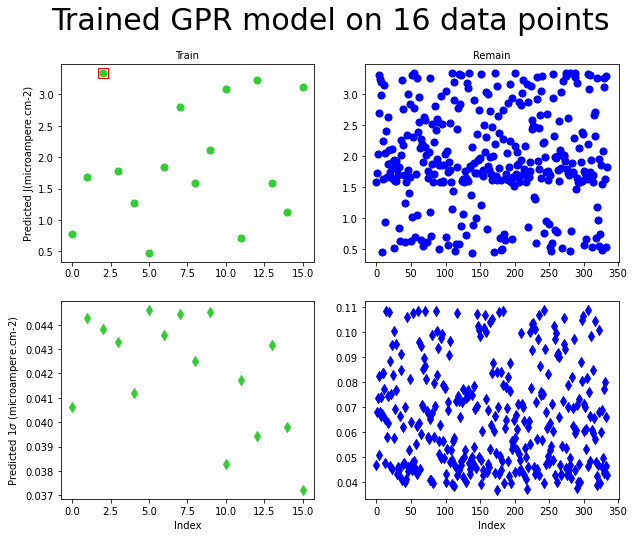

Standard deviation for all data 0.0158651976141159
maximum value from the model 3.3471020647727627
minimum value from the model 0.44506001733644496
baseline at min y= 0.8933695934804445
limit of detection= 9.69861087123331
limit of quantification= 32.12101674266074
signal to noise ratio= 154.6613241746913


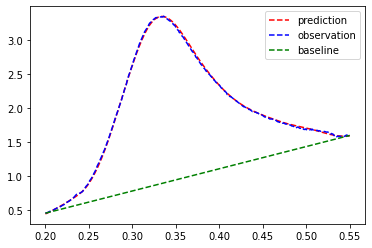

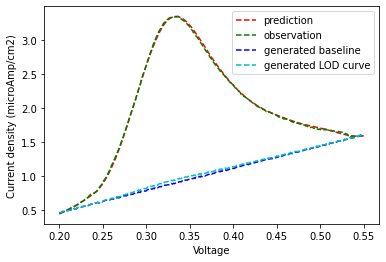

In [449]:

#-------------Step 1---------------------------
fig, axs = plt.subplots(2,2)
fig.set_size_inches(10,8)
titleSize=30
axisTitleSize=10
markerSize=50

fig.suptitle('Trained GPR model on '+str(ntrain)+' data points',fontsize=titleSize)
gpnetwork = gpregression(Xtrain, Ytrain, n_PC)

yt_pred, tsigma = gprediction(gpnetwork, Xtrain)
ybestloc = np.argmax(Ytrain) # The current best y value
ybest_pred = yt_pred[ybestloc]
axs[0,0].scatter(np.arange(len(yt_pred)),yt_pred,color='limegreen',s=markerSize)
axs[0, 0].set_title('Train', fontsize=axisTitleSize)
axs[1,0].scatter(np.arange(len(tsigma)),tsigma,color='limegreen',marker='d',s=markerSize)
axs[0,0].scatter(ybestloc,ybest_pred,color='r',marker='s',s=markerSize+50,facecolor='None') #This line shows the minimum point in the training set
#marked as red square

yr_pred, rsigma = gprediction(gpnetwork, Xremain)
axs[0,1].scatter(np.arange(len(yr_pred)),yr_pred,color='b',s=markerSize)
axs[0, 1].set_title('Remain',fontsize=axisTitleSize)
axs[1,1].scatter(np.arange(len(rsigma)),rsigma,color='b',marker='d',s=markerSize)

axs[0,0].set_ylabel('Predicted J(microampere.cm-2)',fontsize=axisTitleSize)
axs[1,0].set_xlabel('Index',fontsize=axisTitleSize)
axs[1,0].set_ylabel('Predicted 1$\sigma$ (microampere.cm-2)',fontsize=axisTitleSize)
axs[1,1].set_xlabel('Index',fontsize=axisTitleSize)

#---------Step 2-------------------------------------------
ytot_pred,zsigma=gprediction(gpnetwork,Xdata) #Prediction by model with all the data 
baseline=baseline_als(dfJ.Imicroamp,100000,1E-8)
#weight=baseline_alss(dfJ.Imicroamp,1,1)
baselineoptloc=np.argmax(ytot_pred) #This is the observation point where predicted value is minimum that corresponds 
#to baseline data location
#print(baseline[baselineoptloc],np.shape(baseline))
#------------------
#base=dfJ.I
#base=np.asarray(base)
#baseline_values = baseline(base)

#---------------Step 3-------------------------------------
rmse = np.sqrt(np.mean((yt_pred-Ytrain)**2))
print('Current GPR error in microampere.cm-2: RMSE = ', rmse)
rmse2=np.sqrt(np.mean((yr_pred-Yremain)**2))
print('Current GPR error for the remaining data in microampere.cm-2: RMSE=',rmse2)
plt.show()

#-------------Step 4---------------------------------------
standarddeviation=np.sqrt(np.mean((dfJ.Imicroamp-ytot_pred)**2)) # total standard deviation
#standarddeviationbasedonblank=0.0069
print('Standard deviation for all data',standarddeviation)
max(ytot_pred)
min(ytot_pred)
print('maximum value from the model',max(ytot_pred))
print('minimum value from the model',min(ytot_pred))
minimum=min(ytot_pred)
maximum=max(ytot_pred)
if min(ytot_pred)<0:
    minimum=0
if max(ytot_pred)<0:
    maximum=0
#---------Step 5----------------
#Base line generation based on standard deviation at LOD......
baselinegen= (np.random.random_sample(size = Xdata.size))
baselinegenerated=baselinegen*standarddeviation+baseline

#----------Step 6 -------------------    
    
#LOD=(3*concentrationofanalyte*standarddeviation)/abs(max(ytot_pred)-(baseline[baselineoptloc]-standarddeviation))
LOD=(3*concentrationofanalyte*standarddeviation)/abs(max(ytot_pred)-(baseline[baselineoptloc]))
responseatLOD=LOD*(ytot_pred-baseline)/concentrationofanalyte+baselinegenerated
LOQ=(10*concentrationofanalyte*standarddeviation)/abs(max(ytot_pred)- baseline[baselineoptloc]+standarddeviation)
StoNratio=abs(baseline[baselineoptloc]-max(ytot_pred))/standarddeviation
print('baseline at min y=',baseline[baselineoptloc])
print ('limit of detection=',LOD)
print ('limit of quantification=',LOQ)
print('signal to noise ratio=',StoNratio)
# red dashes, blue squares and green triangles
fig, ax = plt.subplots()  # Create a figure and an axes.
ax.plot(Xdata, ytot_pred, 'r--', label='prediction')
ax.plot(Xdata,dfJ.Imicroamp, 'b--', label='observation')
ax.plot(Xdata,baseline,'g--',label='baseline')
ax.legend()
plt.show()

#----------------Step 7--------------------------------------------------
#print('weight=',weight)
#----------------Comparison of baseline with prediction--------------------
fig, ax2=plt.subplots() #Create a figure and axes for comparison generated baseline and prediction
ax2.plot(Xdata, ytot_pred,'r--', label='prediction')
ax2.plot(Xdata,dfJ.Imicroamp, 'g--', label='observation')
ax2.plot(Xdata,baselinegenerated,'b--', label='generated baseline')
ax2.plot(Xdata,responseatLOD,'c--',label='generated LOD curve')
ax2.legend()
ax2.set_xlabel('Voltage', fontsize=axisTitleSize)
ax2.set_ylabel('Current density (microAmp/cm2)', fontsize=axisTitleSize)
plt.show()


List1=Xdata.V
List2=dfJ.Imicroamp
List3=ytot_pred
List4=responseatLOD
col1 = "X"
col2="Observed current GPR"
col3="Predicted current GPR"
col4="LOD curve GPR"
data1 = pd.DataFrame({col1:List1,col2:List2,col3:List3,col4:List4})
data1.to_excel('sample_data500pMGPR.xlsx', sheet_name='sheet1', index=False)


In [450]:
# Step 8: Evaluate the Acquisition Function and suggest next data point/molecule for evaluation
# Parameters for the acquisition function can be adjusted
# At higher epsilon values uncertainities are more prioritized.

Computing EI on the remaining 335 data points


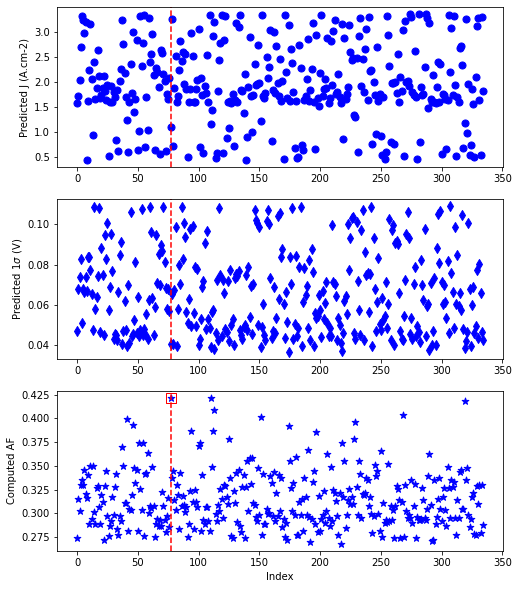

Based on the evalulate AF, the next Observation number to be evaluated is 59


In [451]:
fig, axs = plt.subplots(3)
fig.set_size_inches(8,10)

print('Computing EI on the remaining '+str(ndata-ntrain)+' data points')
epsilon =0.5 # Control exploration/exploitation
expI = expectedImprovement(Xremain, gpnetwork, Yremain, epsilon) #Enter type of acquisition function here
#expI = expectedImprovement(Xremain, gpnetwork, Yremain, epsilon) #Enter type of acquisition function here
upperConfidenceBound(Xremain,gpnetwork,epsilon) #Enter type of acquisition function here
probabilityOfImprovement(Xremain,gpnetwork,ybest_pred,epsilon) #Enter type of acquisition function here
AFmax = np.max(expI)
AFmaxloc = np.argmax(expI)
#AFmax=np.argmax(upperConfidenceBound)
#AFmaxloc = np.argmax(upperConfidenceBound)
#AFmaxloc = np.argmax(probabilityOfImprovement)
XSmilesNew = XremainObsNo[AFmaxloc]

axs[0].scatter(np.arange(len(yr_pred)),yr_pred,color='b',s=markerSize)
axs[0].axvline(AFmaxloc,color='r',ls='--')
axs[0].set_ylabel('Predicted J (A.cm-2)',fontsize=axisTitleSize)

axs[1].scatter(np.arange(len(rsigma)),rsigma,color='b',marker='d',s=markerSize)
axs[1].axvline(AFmaxloc,color='r',ls='--')
axs[1].set_ylabel('Predicted 1$\sigma$ (V)',fontsize=axisTitleSize)


axs[2].scatter(np.arange(len(expI)),expI,color='b',marker='*',s=markerSize)
axs[2].scatter(AFmaxloc,AFmax,edgecolor='r',marker='s',s=markerSize+50,facecolor='None')
axs[2].axvline(AFmaxloc,color='r',ls='--')
axs[2].set_xlabel('Index',fontsize=axisTitleSize)
axs[2].set_ylabel('Computed AF',fontsize=axisTitleSize)

plt.show()
print('Based on the evalulate AF, the next Observation number to be evaluated is '+str(XSmilesNew))



## Step 9: Evaluate the next data point and add to the training set

In [452]:
YJNew = lookupComputedJ(XremainObsNo[AFmaxloc])
ybestloc = np.argmax(Ytrain) # The current best y value
ytrue = Ytrain[ybestloc]

if yopttval > YJNew:  # Identify current obs # with maximum computed J
    yopttval = YJNew
    xoptSmiles = XtrainObsNo[ybestloc]

if XSmilesNew in XtrainObsNo:
    print("New Obs# is already in train set")  
else:
    print('Added '+str(XSmilesNew)+' with J='+str(YJNew)+' A.cm-2 to the training set')
    xtnewObsNo = np.append(XtrainObsNo, XSmilesNew)
    ytnew = np.append(Ytrain, YJNew)
    xtnew = np.append(Xtrain, Xremain[AFmaxloc]).reshape(-1, n_PC)

    xrnew = np.delete(Xremain, AFmaxloc, 0)
    yrnew=np.delete(Yremain, AFmaxloc, 0)      #sonradan ekledim
    xrnewObsNo = np.delete(XremainObsNo, AFmaxloc)

    Xtrain = xtnew
    XtrainObsNo = xtnewObsNo
    Ytrain = ytnew

    Xremain = xrnew
    Yremain=yrnew    #sonradan ekledim
    XremainObsNo = xrnewObsNo
    del xtnew, xtnewObsNo, ytnew, xrnew, xrnewObsNo

ntrain = len(XtrainObsNo)
nremain = len(XremainObsNo)
print('*** Current training set ***')
print(115*'-')
print('{:<5s}{:<5s}{:<15s}'.format('ID','Obs#','J (A.cm-2)'))
print(115*'-')
for i in range(ntrain):
    print('{:<5d}{:<5d}{:<15f}'.format(i,XtrainObsNo[i],Ytrain[i]))
print(115*'-')  
print('Total number of training points: ', ntrain)
print('Total number of remaining points: ',nremain)
print('Current best Obs # (id= '+str(np.argmax(Ytrain))+'), is '+str(xoptSmiles)+' with computed J = '+str(yopttval)+' A.cm-2')
print('***Go back to step 1 to repeat the BO loop***')


Added 59 with J=1.0959999999999999 A.cm-2 to the training set
*** Current training set ***
-------------------------------------------------------------------------------------------------------------------
ID   Obs# J (A.cm-2)     
-------------------------------------------------------------------------------------------------------------------
0    43   0.768000       
1    306  1.691000       
2    138  3.340000       
3    275  1.781000       
4    65   1.269000       
5    6    0.482100       
6    262  1.840000       
7    172  2.800000       
8    343  1.581000       
9    218  2.120000       
10   114  3.080000       
11   36   0.723000       
12   120  3.230000       
13   350  1.599000       
14   60   1.131000       
15   115  3.120000       
16   59   1.096000       
-------------------------------------------------------------------------------------------------------------------
Total number of training points:  17
Total number of remaining points:  334
Current best Obs 